<a href="https://colab.research.google.com/github/NadiaPreuvot/Deep_learning_AT-T-Spam-Detector_Project/blob/main/AT%26T_Spam_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<u><h1><h1 align="center">**AT&T SPAM DETECTOR**</h1>





## <u> Part 1 : Import libraries and load the dataset

<u><h4>1.Import useful modules

In [1]:
# Import Libraries

import pandas as pd
import plotly.express as px
import numpy as np
import tensorflow as tf
import pathlib
import os
import io
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM


<u><h4>2.Load the data

In [2]:
#Import dataset with Pandas
print("Loading dataset...")
df=pd.read_csv("/content/spam.csv", encoding="ISO-8859-1")
print("...Done")

Loading dataset...
...Done


## <u> Part 2 : Understand the data  

<u><h4>1.Understand the data

In [3]:
#Basic stats
print("Number of rows: {}".format(df.shape[0]))
print("Number of columns: {}".format(df.shape[1]))
print()

print ("Display of dataset: ")
display(df.head())
print()

print ("Basics statistics: ")
df_desc= df.describe(include="all")
display(df_desc)
print()

print ("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows: 5572
Number of columns: 5

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

***observations:***


*   The primary columns of interest are ***v1***, which contains labels ('ham' for non-spam and 'spam' for spam messages), and ***v2***, which contains the SMS message content.
*   The columns Unnamed: 2, Unnamed: 3, and Unnamed: 4 appear to have a significant number of missing values.





<u><h4>2.Data cleaning

The columns Unnamed: 2, Unnamed: 3, and Unnamed: 4 have an exceptionally high percentage of missing values (approximately 99.1%, 99.78%, and 99.89% respectively), indicating that these columns are largely irrelevant for the analysis of spam detection. This suggests that the dataset's useful information is primarily contained within the v1 (label) and v2 (text) columns.

In [4]:
#Drop unuseful columns "Unnamed: 2"/"Unnamed: 3"/"Unnamed: 4"

print("Dropping uselss columns...")
df = df.drop(df.columns[[2,3,4]], axis=1)
print("...Done")
df.head()


Dropping uselss columns...
...Done


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<u><h4>3.Data Distribution

In [5]:
# Plotting the counts of v1 (ham and spam)
fig = px.histogram(df, x='v1',
                   title="Class Distribution (Spam vs Ham)",
                   text_auto=True, # Afficher le nbr d'obs sur le graph
                   )

fig.update_layout(yaxis_title="Number of Observations", # Titre de l'axe des ordonnées
                  bargap=0.2, # Ajuster l'espacement entre les barres
                  )

fig.show()


***observations***:

The v1 column, which indicates whether a message is spam or not, shows that the dataset is imbalanced with a higher frequency of 'ham' (non-spam) messages (4,825 occurrences) compared to 'spam' messages.

In [6]:
#Convert labels to ham=0 and spam=1
df["v1"]=df["v1"].apply(lambda x: 0 if x == "ham" else 1)
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## <u> Part 3 : Preprocessing

### <u> Clean up the character strings

<u><h4>1.Download spaCy's English model

In [7]:
# Download all language elements related to the English language

print("Loading...")
! python -m spacy download en_core_web_md -q
print("...Done")

Loading...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 5.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
...Done


In [8]:
# Import Spacy and English initialisation into nlp variable

print("Loading...")
import en_core_web_md
nlp = en_core_web_md.load()
print("...Done")


Loading...
...Done


<u><h4>2. Managing Stop Words in Text Analysis with spaCy

In [9]:
# Import English Stop Words
from spacy.lang.en.stop_words import STOP_WORDS

<u><h4>3.Text Preprocessing for Analysis with spaCy

In [10]:
# Cleaning the texts in order to prepare them for training

df["review_clean"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'" ))
df["review_clean"] = df["review_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["review_clean"] = df["review_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

df.head()


,v1,v2,review_clean
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


<u><h4>4.Data Filtering with Type Checking

In [31]:
print(" Data string filtering ...")
mask= df.review_clean.apply(lambda x: type(x) == str)
mask.value_counts()
print("...Done")

 Data string filtering ...
...Done


***observations***:

All 5572 rows in the review_clean column are strings, confirming data uniformity and readiness for text processing with no rows excluded."

### <u>Comprehensive Data Preparation for NLP

<u><h4>1.Encoding all the reviews

In [12]:
#Instanciate the tokenizer and text encoding

print("Tokenizing and encoding...")
tokenizer = tf.keras.preprocessing.text.Tokenizer ( num_words= 1000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df["review_clean"])
df["review_encoded"] = tokenizer.texts_to_sequences(df["review_clean"])
print("...Done")

Tokenizing and encoding...
...Done


In [13]:
df.head()

,v1,v2,review_clean,review_encoded
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 232, 446, 462, 939, 32, 50, 206, 940, 78, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[8, 195, 463, 290, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 302, 3, 528, 657, 30, 1, 842, 423, 1, 1, ..."
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 125, 149, 1, 2, 79]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[702, 20, 658, 130]"


<u><h4>2.Padding

In [14]:
# Normalizing the lengths' sequences

print(" Adjusting the review_encoded to the same length...")
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(df.review_encoded, padding="post")
print("...Done")

 Adjusting the review_encoded to the same length...
...Done


<u><h4>3.Train_test_split using sklearn

In [15]:
#Train Test Split
print("Split data into training and validation sets...")
x_train, x_val, y_train, y_val = train_test_split(reviews_pad, df["v1"], test_size=0.3)
print("...Done")

Split data into training and validation sets...
...Done


<u><h4>4.Create a Tensor dataset

In [16]:
print("Creating TensorFlow Dataset Objects for Train and Val...")
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
print("...Done")

Creating TensorFlow Dataset Objects for Train and Val...
...Done


<u><h4>5.Batching and Shuffling

In [17]:
#Batching and Shuffling the training and validation data
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [18]:
#Visualizing a batch of data
for review_encoded, v1 in train_batch.take(1):
  print(review_encoded.numpy(), v1.numpy())


[[ 20 130  11 ...   0   0   0]
 [  4 182  30 ...   0   0   0]
 [174   8  23 ...   0   0   0]
 ...
 [234   1  58 ...   0   0   0]
 [  1  31 153 ...   0   0   0]
 [ 27  39   1 ...   0   0   0]] [1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0]


## <u> Part 4 : Modeling

### <u> First Model : Global Average Pooling

<u><h4> 1. Building

In [19]:
# Create a model
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
    # Couche d'Input Word Embedding
    tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[reviews_pad.shape[1],], name="embedding"),
    # Global average pooling
    tf.keras.layers.GlobalAveragePooling1D(),
    # Couche Dense classique
    tf.keras.layers.Dense(16, activation='relu'),
    # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 8)             8008      
                                                                 
 global_average_pooling1d (  (None, 8)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8169 (31.91 KB)
Trainable params: 8169 (31.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


***observations:***



1.   Embedding Layer :
*   Each word is represented by a vector of 8 elements.
*   For each input, this layer produces an output of shape 74x8 where 74 is the length of the input sequences.
*  The number of parameters "8008" in this layer is calculated as the number of words in the vocabulary.

2.   Global Average Pooling 1D Layer
*   This layer reduces each example from its 74x8 dimension to a 1x8 dimension
*   The output of this layer is a vector of size 8 for each review.
*   Param: 0. This layer has no learnable parameters.


3.   First Dense Layer
*   It is a fully connected layer with 16 units.
*   The output is a vector of size 16 for each review.
*   Param : 144 either (8 * 16) + 16 = 144

4.   Second Dense Layer (Output Layer)
*   It is the output layer with a single unit for binary classification.
*   The output is a scalar value representing the probability that the input belongs to the positive class.
*   Param: 17 either (16 * 1) + 1 = 17.



<u><h4> 2.Compiling the model

In [21]:
#Compiling with Adam optimizer and Binary CrossEntropy Loss
optimizer= tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])


<u><h4> 3. Training the model

In [22]:
# Fit the model on 50 epochs
history = model.fit(train_batch, epochs=50, validation_data=val_batch)


Epoch 1/50
61/61 [==============================] - 3s 13ms/step - loss: 0.6138 - binary_accuracy: 0.8644 - val_loss: 0.5316 - val_binary_accuracy: 0.8696
Epoch 2/50
61/61 [==============================] - 1s 9ms/step - loss: 0.4591 - binary_accuracy: 0.8644 - val_loss: 0.3924 - val_binary_accuracy: 0.8696
Epoch 3/50
61/61 [==============================] - 0s 7ms/step - loss: 0.3754 - binary_accuracy: 0.8644 - val_loss: 0.3565 - val_binary_accuracy: 0.8696
Epoch 4/50
61/61 [==============================] - 1s 12ms/step - loss: 0.3570 - binary_accuracy: 0.8644 - val_loss: 0.3462 - val_binary_accuracy: 0.8696
Epoch 5/50
61/61 [==============================] - 1s 8ms/step - loss: 0.3462 - binary_accuracy: 0.8644 - val_loss: 0.3360 - val_binary_accuracy: 0.8696
Epoch 6/50
61/61 [==============================] - 1s 9ms/step - loss: 0.3337 - binary_accuracy: 0.8644 - val_loss: 0.3241 - val_binary_accuracy: 0.8696
Epoch 7/50
61/61 [==============================] - 0s 6ms/step - loss: 0.

***observations:***


*   We observe that the loss decreases constantly from epochs to epochs.
which indicates that the model is improving and learning from the training set.
*   val_loss: This value also decreases, which is a good sign. The model does not overfit and generalizes well to new data.
*   binary_accuracy: The increase, both on training and validation, suggests that the model is becoming more accurate in its predictions.







<u><h4> 4. Evaluation

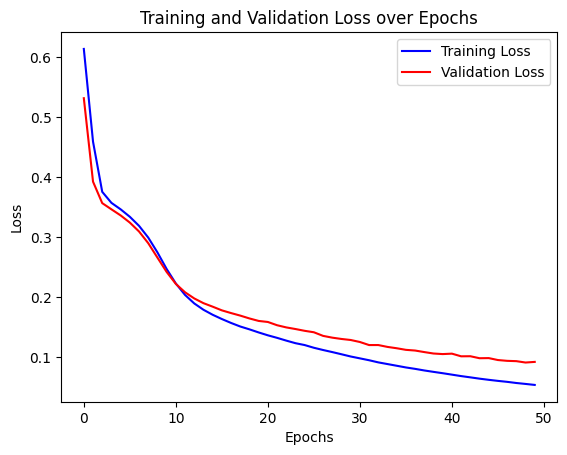

In [23]:
# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b", label="Training Loss")
plt.plot(history.history["val_loss"], color="r", label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()


observations:


*   Blue Curve (Training Loss): It shows the loss on the training set. We observe a rapid decrease in the loss during the first epochs, followed by a slower and more stable decrease. This indicates that the model learns and improves quickly at first, then continues to improve at a more measured rate.

*   Red Curve (Validation Loss): It shows the loss on the validation set. Like the blue curve, the validation loss decreases quickly at first, indicating that the model generalizes well to unseen data. The validation curve continues to closely follow the training curve, suggesting that the model is not significantly overlearning.




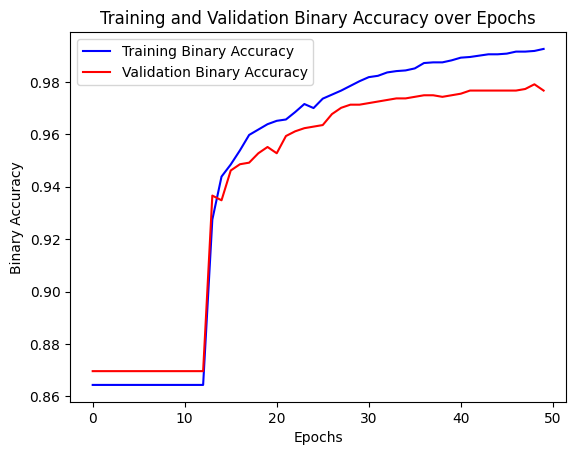

In [24]:
# Visualization of accuracy training
plt.plot(history.history["binary_accuracy"], color="b", label="Training Binary Accuracy")
plt.plot(history.history["val_binary_accuracy"], color="r", label="Validation Binary Accuracy")
plt.title("Training and Validation Binary Accuracy over Epochs")
plt.ylabel("Binary Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()



***observations***


*   Blue Curve (Training Accuracy): It represents the binary precision on the training set. It shows how accuracy improves over epochs, indicating that the model is becoming more and more proficient at making correct predictions with the training data.
*   Red Curve (Validation Accuracy): The red curve represents the binary accuracy on the validation set. This curve is particularly important because it shows how the model performs on data it didn't see during training. Like the blue curve, the red curve shows an increase in accuracy over time, suggesting that the model generalizes well to new data.



### <u> Second Model : GRU

<u><h4> 1. Building

In [25]:
# Define the vocabulary size and Create a GRU model

vocab_size = tokenizer.num_words
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 64, input_shape=[reviews_pad.shape[1],], name="embedding"),
    tf.keras.layers.GRU(units=32, return_sequences=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [26]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 64)            64064     
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 73505 (287.13 KB)
Trainable params: 73505 (287.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<u><h4> 2.Compiling the model

In [27]:
#Compiling with Adam optimizer and Binary CrossEntropy Loss
optimizer= tf.keras.optimizers.Adam()
model_gru.compile(optimizer=optimizer,
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=[tf.keras.metrics.BinaryAccuracy()])

<u><h4> 3. Training the model

In [28]:
# Model training on 40 epochs
history = model_gru.fit(train_batch, epochs=40, validation_data=val_batch)

Epoch 1/40
61/61 [==============================] - 5s 51ms/step - loss: 0.4614 - binary_accuracy: 0.8413 - val_loss: 0.3871 - val_binary_accuracy: 0.8696
Epoch 2/40
61/61 [==============================] - 4s 60ms/step - loss: 0.3974 - binary_accuracy: 0.8644 - val_loss: 0.3882 - val_binary_accuracy: 0.8696
Epoch 3/40
61/61 [==============================] - 3s 43ms/step - loss: 0.3977 - binary_accuracy: 0.8644 - val_loss: 0.3888 - val_binary_accuracy: 0.8696
Epoch 4/40
61/61 [==============================] - 3s 50ms/step - loss: 0.3988 - binary_accuracy: 0.8644 - val_loss: 0.3912 - val_binary_accuracy: 0.8696
Epoch 5/40
61/61 [==============================] - 3s 56ms/step - loss: 0.3978 - binary_accuracy: 0.8644 - val_loss: 0.3884 - val_binary_accuracy: 0.8696
Epoch 6/40
61/61 [==============================] - 3s 43ms/step - loss: 0.3995 - binary_accuracy: 0.8644 - val_loss: 0.3909 - val_binary_accuracy: 0.8696
Epoch 7/40
61/61 [==============================] - 4s 73ms/step - los

*** observations :***


*   Loss: The loss on the training set starts higher and gradually decreases, indicating that the model is improving and fitting the training data.
By reaching very low values, it suggests that the model has become very accurate on the training set.
*   val_loss: It also decreases, indicating that the model generalizes well to unseen data.
However, the validation loss starts to oscillate slightly after epoch 20, which may be a sign of beginning overfitting.
*   Binary_accuracy: It starts at a reasonable level and remains relatively stable across epochs.
however it increases around the 22nd epochs to near-perfect levels, reflecting the reduction in loss.
*   val_binary_accuracy: The validation precision remains fairly stable, which is a good sign of generalization then it increases around 22 epochs but at times drops a little.





<u><h4> 4. Evaluation

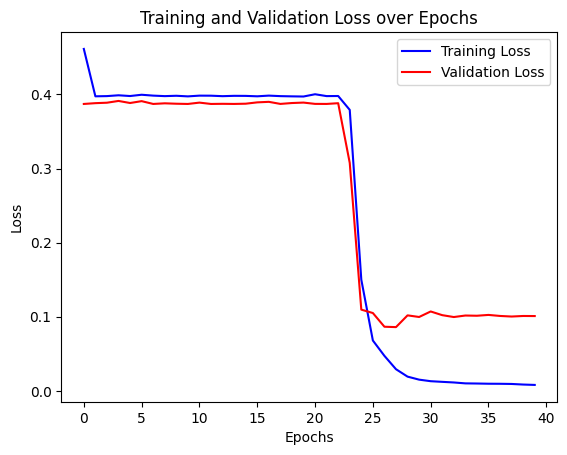

In [29]:
 # Visualization of the training process on the loss function

plt.plot(history.history["loss"], color="b", label="Training Loss")
plt.plot(history.history["val_loss"], color="r", label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()


***observations:***


*   we can see that both loss curves decrease and stabilize around the 20th epoch. This indicates that the model is improving and learning on both the training and validation data up to this point.y.

*   The training loss is lower than the val_loss.This generally indicates that the model has learned the training data better and may not perform as well of course data that he didn't see during training. It is a signe of overfitting.





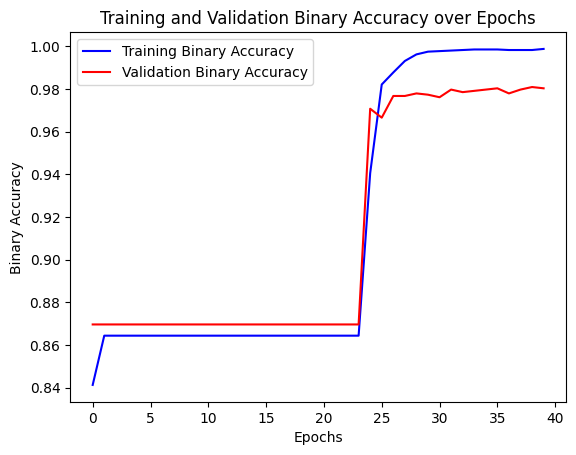

In [30]:
# Visualization of accuracy training
plt.plot(history.history["binary_accuracy"], color="b", label="Training Binary Accuracy")
plt.plot(history.history["val_binary_accuracy"], color="r", label="Validation Binary Accuracy")
plt.title("Training and Validation Binary Accuracy over Epochs")
plt.ylabel("Binary Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()



***observations:***

*   Both curves follow a similar trend with a rapid increase. However, after the initial peak, the val_binary fluctuates and tends to be slightly lower than the training one, indicating a possible divergence between learning on the training set and generalization on the validation set.
This divergence can be an indicator of overfitting.

